In [ ]:
import pickle
import time
start_time = time.time()
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import SimpleITK as sitk
import json
import ProstateLesionDetectionUtils
import random
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import ndimage
import math
import tensorflow_addons as tfa
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

with open(r"E:\DIMITRIS_DEEP_LEARNING\DATASETS\UC1_Nifti_Datasets_Paths\Datasets.json", 'r') as f:
    datasets = json.load(f)
for dataset in datasets.keys():
    for pat in datasets[dataset].keys():
        for seq in datasets[dataset][pat].keys():
            x = datasets[dataset][pat][seq]
            x = x.replace("\\","/")
            datasets[dataset][pat][seq] = x
# p158 = r"E:\DIMITRIS_DEEP_LEARNING\DATASETS\PROSTATE158\DATASETPICKLE\Nifti_files"
# picai = r"E:\DIMITRIS_DEEP_LEARNING\DATASETS\PICAI_DATA\Nifti_files"
prostatenet = "ProstateNetData/Dataset013_ProstateNet_Not_Integerized"
with open("ProstateNetData/folds.json", 'r') as f:
    ValidationFolds = json.load(f)
    

def PrepareTraining(pat, seq_ls =None):
    dataset, labels = {}, {}
    for key in pat.keys():
        ds = []
        for item in seq_ls:
            ds.append(pat[key][item])
        dataset.update({key:np.transpose(np.stack(ds),(1,2,3,0))}) # tf.convert_to_tensor

    
        labels.update({key:np.expand_dims(pat[key]["Lesions"], axis = -1)}) # tf.convert_to_tensor
    return dataset, labels

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
loader = ProstateLesionDetectionUtils.DatasetsLoaders.Nifti_Loader.LoadSitkImages(ptdc = datasets["ProstateNet_Not_Integerized"], folder = prostatenet)
patients = loader.load_npobj()

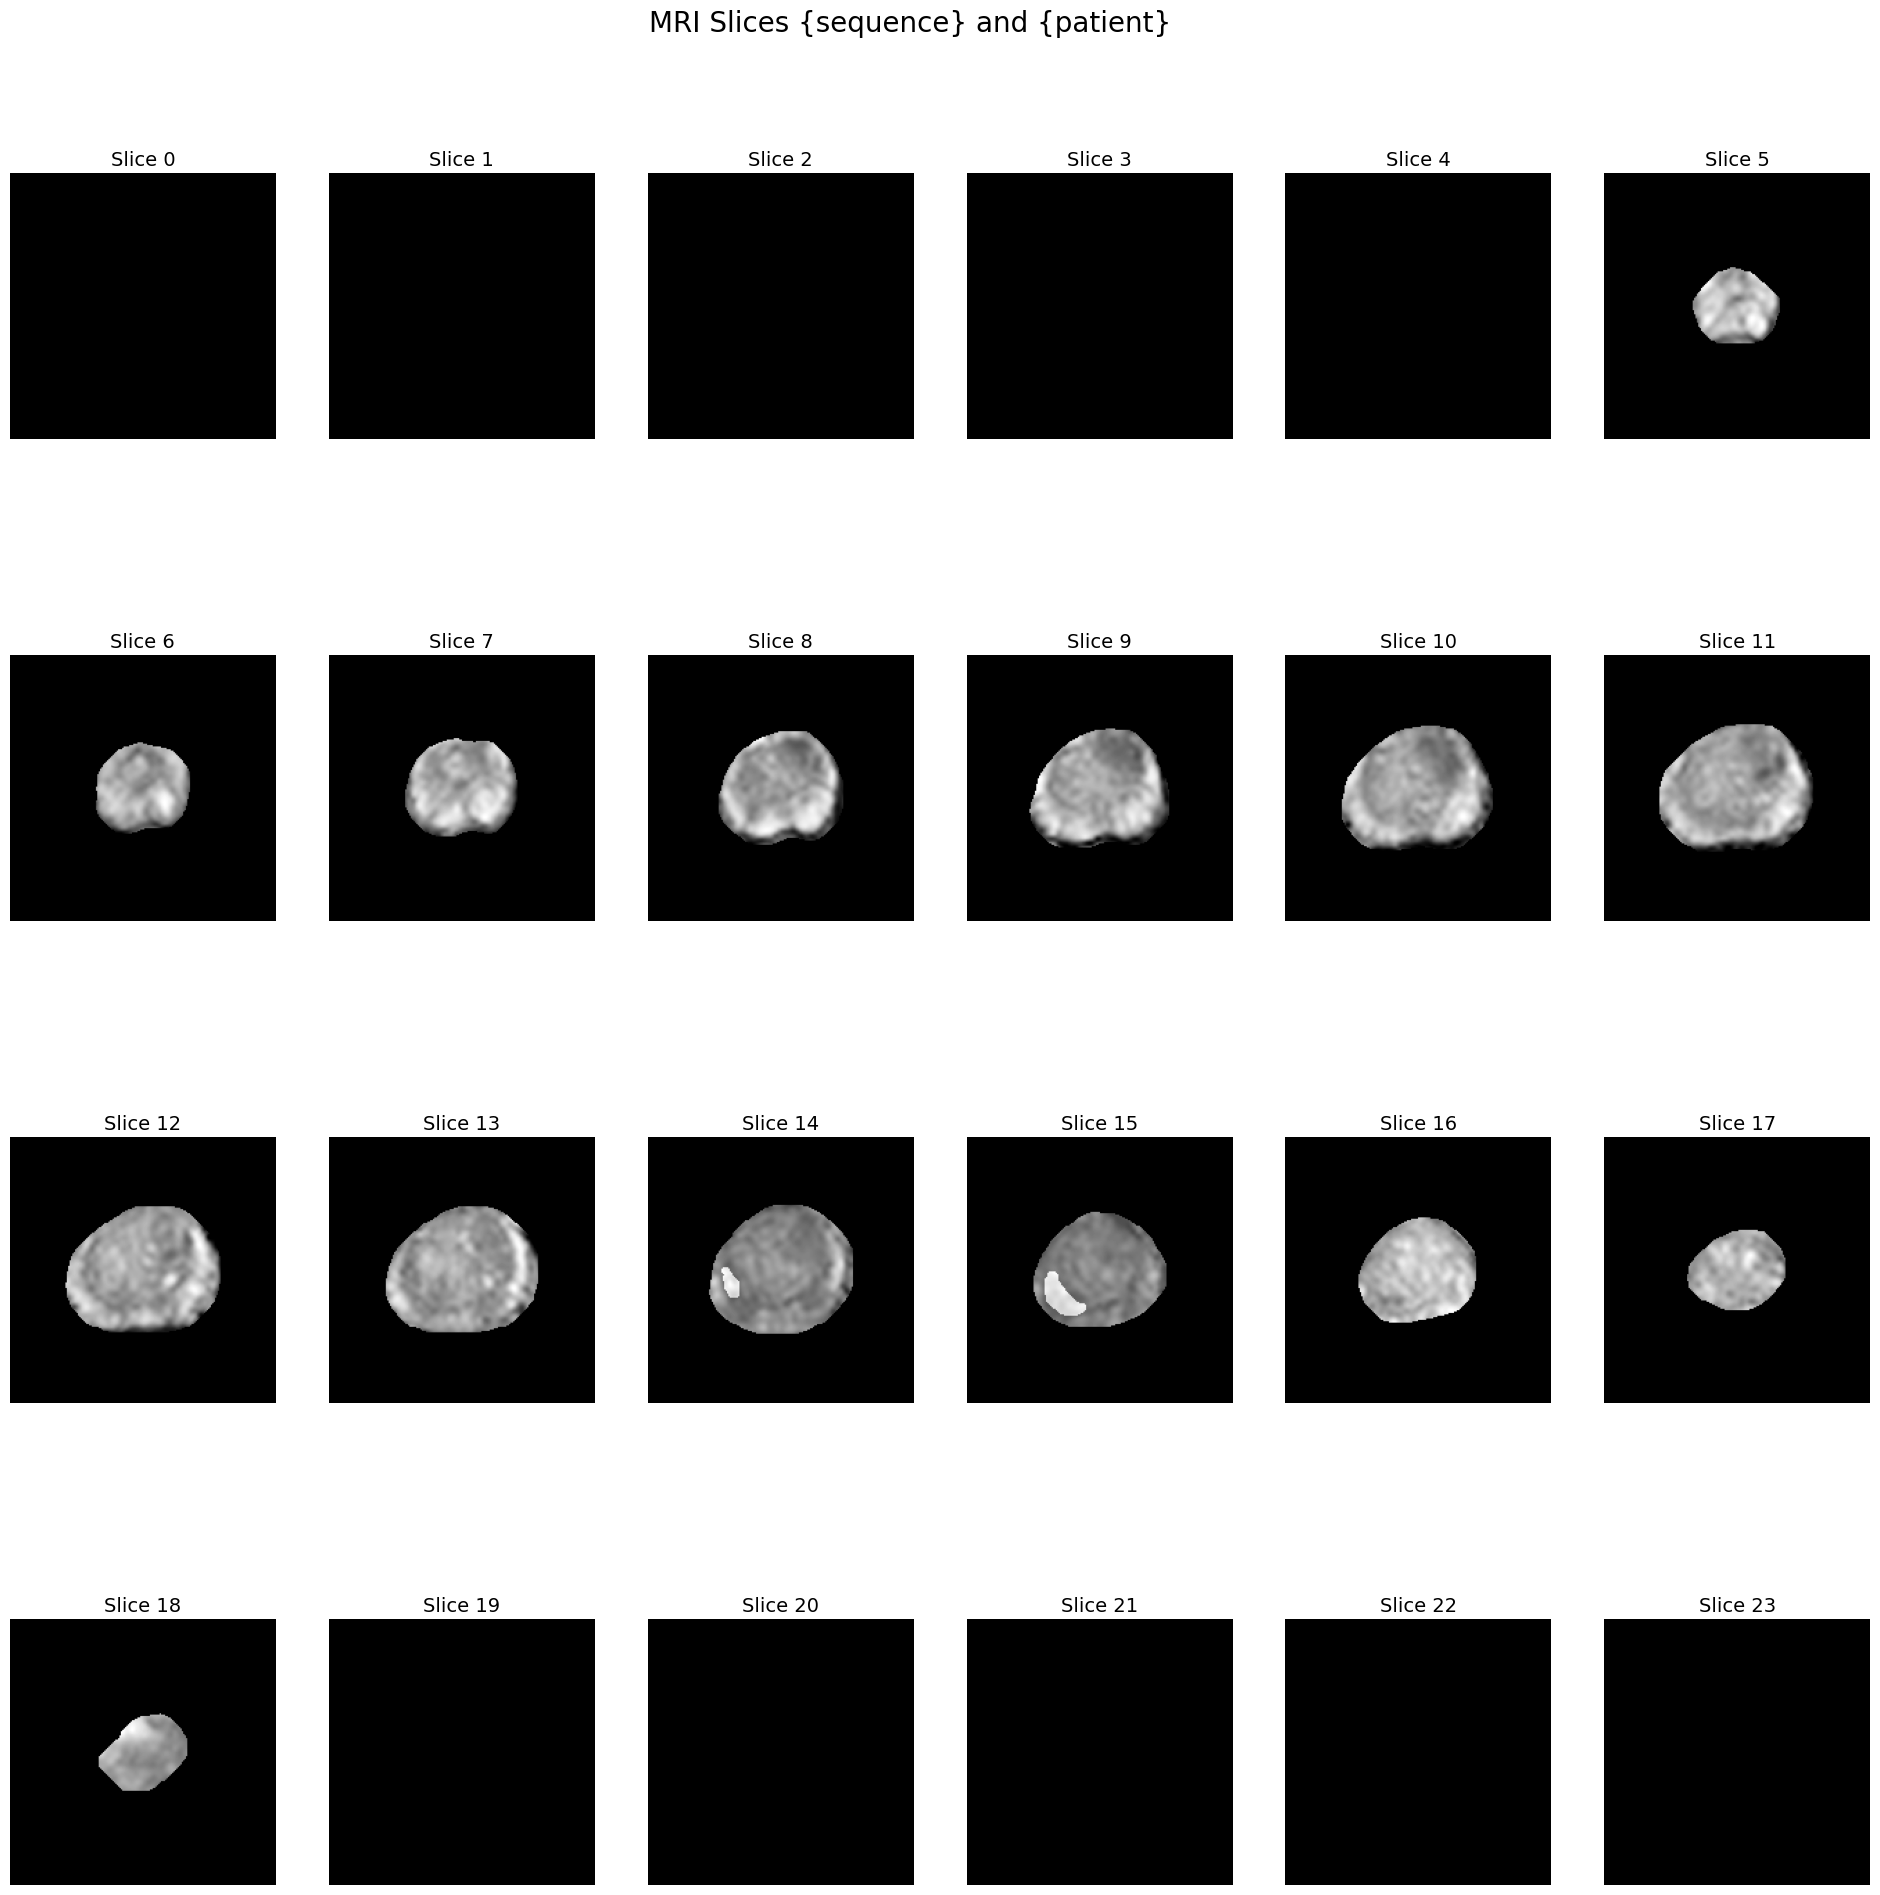

In [8]:
vis = ProstateLesionDetectionUtils.DatasetsProcessing.Visualization.Visualizer(patients)
vis.np_vis("DWI", "PCa-324365095643606010864476831387746614101",alpha=0.01)

In [ ]:
dt = ProstateLesionDetectionUtils.DetectionMetrics.ModelDetoriention.DetorientLesions(patients, rates = [15,40,50])
dt.CreateZones()
dt.CreateZaxisZone()
dt.KeepZonesNonZeroImageValues()
zones = dt.GetZones()
zaxis = dt.GetZaxisZones()

In [ ]:
dataset, labels = PrepareTraining(patients, seq_ls=["T2", "ADC", "DWI"])

x_train = {key:dataset[key] for key in dataset.keys() if key not in ValidationFolds["Fold 0"]}
y_train = {key:labels[key] for key in labels.keys() if key not in ValidationFolds["Fold 0"]}

x_test = {key:dataset[key] for key in dataset.keys() if key in ValidationFolds["Fold 0"]}
y_test = {key:labels[key] for key in labels.keys() if key in ValidationFolds["Fold 0"]}

In [10]:
len(x_train),len(y_train),len(x_test),len(y_test)

(289, 289, 73, 73)

In [ ]:
Xtrain = np.array(list(x_train.values()))
Ytrain = np.array(list(y_train.values()))
Xtest = np.array(list(x_test.values()))
Ytest = np.array(list(y_test.values()))

In [ ]:

start_time = time.time()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
FILTERS = [32, 64, 128, 256, 512, 1024, 2048] # -> best filters [32, 64, 128, 256, 512, 1024]
Pool_size = ((1,2,2),(1,2,2),(2,2,2), (2,2,2), (1,2,2), (1,2,2))# best pool size-> (1,2,2),(1,2,2),(2,2,2), (2,2,2), (2,2,2)
VOLSIZE = 24
INPUT_SIZE = (1,24,192,192,3)
BATCH_SIZE=1
EPOCHS = 250
INIT_LR = 0.0001
MAX_LR = 0.05
TQDM_CB=tfa.callbacks.TQDMProgressBar()

METRICS = [ProstateLesionDetectionUtils.Evaluation.Loss_functions.dice_coefficient] # tfa.metrics.F1Score(num_classes=2, threshold=0.5)

STEPS_PER_EPOCH = len(Xtrain) // BATCH_SIZE # len(train_data)

# CLR = lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     0.001,
#     decay_steps=STEPS_PER_EPOCH,  # Usually set to total number of training steps/epochs
#     decay_rate=0.96,
#     staircase=True
#)
CLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * STEPS_PER_EPOCH)
LOSS = ProstateLesionDetectionUtils.Evaluation.Loss_functions.combined_loss#tfa.losses.sigmoid_focal_crossentropy  #tfa.losses.sigmoid_focal_crossentropy
OPTIMIZER = tf.keras.optimizers.legacy.Adam(CLR)

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history, save_path="history.png"):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['dice_coefficient'])
    plt.plot(history['val_dice_coefficient'])
    plt.title('Model accuracy')
    plt.ylabel('Dice_coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=400)

In [20]:
# Creating the experiment folder's structure
par_folder = "EXPERIMENTS_V0.2"
folds = ["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"]
models = ['Unet', 'Attention_Unet', 'Vnet', 'USE_net', 'Dense2_Unet', 'Trans_Unet']
subfolds = ['Models',
 'Ground_Truth',
 'GradCam',
 'Feature_Maps',
 'Binary_Predictions',
 'Metrics_Json',
 'predictions']

os.mkdir(par_folder)
for item in models:
    os.mkdir(os.path.join(par_folder,item))
    for sub in folds:
        os.mkdir(os.path.join(*[par_folder,item,sub]))
        for sub2 in subfolds:
            os.mkdir(os.path.join(*[par_folder,item,sub,sub2]))


In [ ]:
exp = 'EXPERIMENTS_V0.2'
models = ['Unet', 'Attention_Unet', 'Vnet', 'USE_net', 'Dense2_Unet', 'Trans_Unet']
mod_instances = [
ProstateLesionDetectionUtils.DetectionModels.Models3D.UnetModel3D.UNET.TrainUnet,
ProstateLesionDetectionUtils.DetectionModels.Models3D.AttentionUNet3D.AttentionUNet.TrainAttentionUnet,
ProstateLesionDetectionUtils.DetectionModels.Models3D.VNet.vnet.TrainVnet,
ProstateLesionDetectionUtils.DetectionModels.Models3D.USENet3D.USENET.TrainUSEnet,
ProstateLesionDetectionUtils.DetectionModels.Models3D.Dense2VNet.D2Vnet.TrainDenseVnet,
ProstateLesionDetectionUtils.DetectionModels.Models3D.TransUnet3D.transunet3d.TrainTransUnet,
]

TrainParams = {"LOSS":LOSS, "OPTIMIZER":OPTIMIZER, "CALLBACKS":None,"POOL_SIZE":Pool_size,
            "BATCH_SIZE":BATCH_SIZE, "FILTERS":FILTERS, "INPUT_SIZE":INPUT_SIZE, "METRICS":METRICS,
            "INITIAL_WEIGHTS":None,
            "WEIGHTS":None,
            "VOLUME_SIZE":24, "EPOCHS":EPOCHS, 
            "TRAIN_DATASET":{"DATA":Xtrain,"LABELS":Ytrain},"VAL_DATASET":{"DATA":Xtest,"LABELS":Ytest},
            "DENSE_SIZE":16, "GROWTH_RATE": 2, "DROPOUT_RATE": 0.3, "DENSE_BLOCKS": 2,
            "PATCH_SIZE_XY": 3,
            "PATCH_SIZE_Z": 1,
            "TRANSF_HEADS": 8,
            "TRANSF_LAYERS": 8,
            "DROP_RATE": 0.3}

for mdl_pth, mdl in zip(models,mod_instances):
    #if  mdl_pth == "Trans_Unet": #mdl_pth == "Dense2_Unet"
    pth_check = [exp,mdl_pth,"fold_0","Checkpoint_2048.tf"]
    pth_final = [exp,mdl_pth,"fold_0","Final_2048.tf"]
    pth_init = [exp,mdl_pth,"init_weights_2048.h5"]

    CHECK_CB = tf.keras.callbacks.ModelCheckpoint(os.path.join(*pth_check),save_weights_only=False,save_best_only=True)
    CALLBACKS=[CHECK_CB]#
    TrainParams["CALLBACKS"] = CALLBACKS
    TrainParams["INITIAL_WEIGHTS"] = os.path.join(*pth_init)
    TrainParams["WEIGHTS"] = os.path.join(*pth_final)

    mod = mdl(TrainParams)
    mod.ModelBuild()

    if "init_weights_2048.h5" in os.listdir(os.path.join(exp,mdl_pth)):
        mod.LoadTrained()
    else:
        mod.SaveInitWeights()
    mod.LoadTrained()
    mod.ModelCompile()
    mod.ModelFit()

    mod1 = mod.GetModel()
    hist = mod.GetHistory()
    plot_history(hist.history, save_path=os.path.join(*[exp,mdl_pth,"fold_0",f"plot_{pth_check[-1][7:-3]}"]))
    mod1.save(TrainParams["WEIGHTS"])